In [3]:
import matplotlib.pyplot as plt
import readsnapGadget2 as snap
import numpy as np
import pickle
from copy import copy
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [4]:
# read the simulation result
snapnum = 95
filename = f"data/snapshot_{str(snapnum).zfill(3)}"
head = snap.snapshot_header(filename) # read the header
pos = snap.read_block(filename, "POS ")
mass = snap.read_block(filename, "MASS")

# create copy of particle locations. It stores the locations of particles that have not been grouped yet.
particles = pos.copy()
n_particles = len(pos)

# linking length for friends of friends algo
boxsize = head.boxsize 
link_len = 0.2*(boxsize**3/n_particles)**(1/3) #kpc formula: 0.2*(V/N)^(1/3)

assert head.redshift < 1e-10 #present time
assert boxsize == 50000

In [5]:
print(f"The total number of particles is {n_particles}")

The total number of particles is 262144


In [6]:
# This calculates the 3d distance between the selected particle and all the other particles that have not been grouped
def distance(other_particles, particle):
    # get the differece in x, y, z coordinates
    dx = other_particles[:, 0] - particle[0]
    dy = other_particles[:, 1] - particle[1]
    dz = other_particles[:, 2] - particle[2]
    # account for periodic boundary conditions
    dx[dx > boxsize/2] = boxsize - dx[dx > boxsize/2]
    dy[dy > boxsize/2] = boxsize - dy[dy > boxsize/2]
    dz[dz > boxsize/2] = boxsize - dz[dz > boxsize/2]
    
    dist = (dx**2 + dy**2 + dz**2)**0.5
    return dist

In [7]:
groups = {} # Positions of halo particles
sizes = {} # size of the halo (# of particles in it)
group_id = 0 # initial group id
pbar = tqdm(total=len(particles)) # progress bar

while len(particles) > 0:
    part = particles[0] # location of first particle
    dists = distance(particles, part)
    
    # add close-enough particles to the current group, and remove them
    mask = np.where(dists < link_len)[0]
    groups[group_id] = particles[mask]
    particles = np.delete(particles, mask, axis=0)
    
    '''Find the friends of friends of part'''
    pointer = 1 # for whom we are looking for more friends? the index of elements in groups[group_id]
    num_friends = len(groups[group_id])
    while pointer < num_friends:
        # get position and distances of the friend being considered, and which are close enough
        part_friend = groups[group_id][pointer]
        dists = distance(particles, part_friend)
        mask = np.where(dists < link_len)[0]
        
        # if we found friends of that friend, add to current group and delete from particle list
        if len(mask) > 0:
            friends_of_friend = particles[mask]
            groups[group_id] = np.concatenate([groups[group_id], friends_of_friend])
            particles = np.delete(particles, mask, axis=0)

        pointer +=1
        num_friends = len(groups[group_id])
    
    '''Current group completed. Move on to the next group'''
    sizes[group_id] = len(groups[group_id]) 
    group_id += 1
    pbar.update(1)

Gonna plot


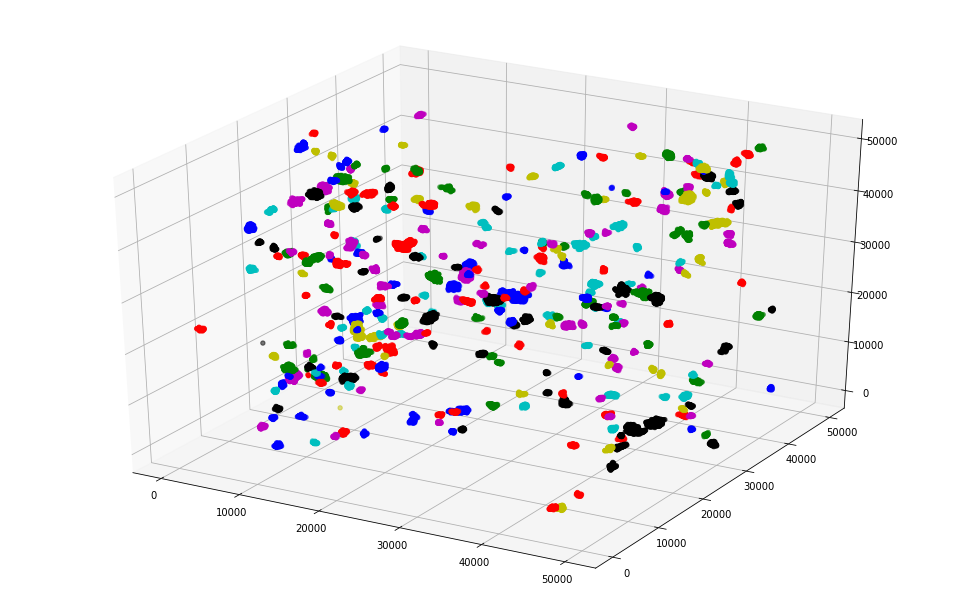

In [10]:
# # Try to plot halos (2d projection) but takes lots of time to run. There has to be a better way of doing this

colorlist = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# plt.figure(figsize=(8,8))
# for i in range(group_id):
#     if sizes[i]>20:
#         for j in range(sizes[i]):
#             plt.plot(groups[i][j][0], groups[i][j][1], '.', color=colorlist[i%7])
# plt.xlim(0, boxsize)
# plt.ylim(0, boxsize)
# plt.grid()

xs, ys, zs, col = [], [], [], []
for i in range(group_id):
    if sizes[i] > 50:
        for j in range(sizes[i]):
            xs += [groups[i][j][0]]
            ys += [groups[i][j][1]]
            zs += [groups[i][j][2]]
            col += [colorlist[i%7]]

print("Gonna plot")
fig = plt.figure(figsize=(17, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, marker='.', s=75, c=col)
plt.show()

In [63]:
groupsize_max = int(np.amax(np.fromiter(sizes.values(), dtype=float)))
biggest_halo_mass = groupsize_max*mass[0]
print(f"The largest halo (of total # {group_id}) has a mass of {biggest_halo_mass} x 10^10 solar masses.")
assert len(set(mass)) == 1

The largest halo (of total # 134021) has a mass of 8161.522034645081 x 10^10 solar masses.


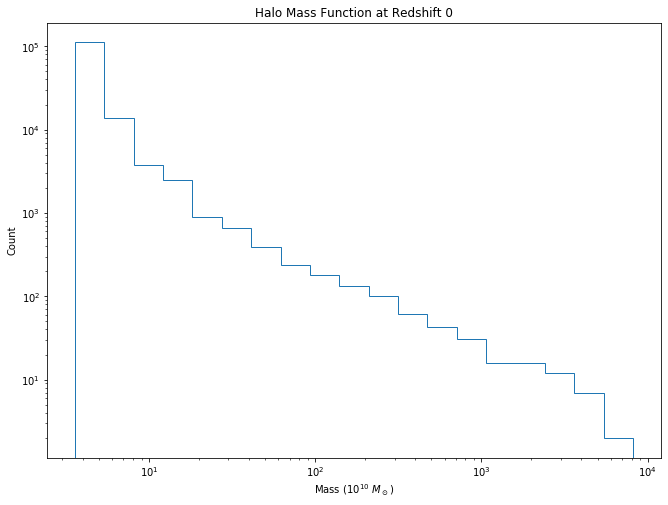

In [83]:
mass_of_halos = np.fromiter(sizes.values(), dtype=float)*mass[0]
mass_bins = np.logspace(np.log10(min(mass_of_halos)), np.log10(max(mass_of_halos)), num=20)
plt.figure(figsize=(11, 8))
plt.hist(mass_of_halos, bins=mass_bins, histtype='step')
plt.xscale('log')
plt.yscale('log')
plt.title("Halo Mass Function at Redshift 0")
plt.xlabel("Mass ($10^{10}\ M_\odot$)");
plt.ylabel("Count");

In [18]:
pickle.dump(groups, open( "groups.pickle", "wb"))
pickle.dump(sizes, open("sizes.pickle", "wb"))
groups_load = pickle.load(open( "groups.pickle", "rb" ))
sizes_load = pickle.load(open( "sizes.pickle", "rb" ))

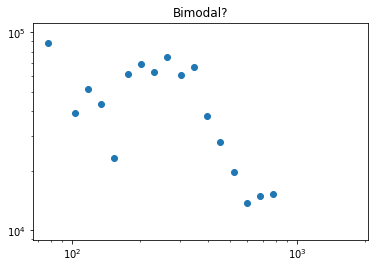

In [171]:
closest_dist, largest_dist = min(dists_from_com), max(dists_from_com)
bins = np.logspace(np.log10(closest_dist), np.log10(largest_dist), num=25)
sphere_vols = np.array([(4/3)*np.pi*radius**3 for radius in bins])
sph_shell_vols = np.diff(sphere_vols)
cts, bin_edges = np.histogram(dists_from_com, bins=bins)
assert len(sph_shell_vols) == len(cts)
y_axis = cts*mass[0]*1e10/sph_shell_vols
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.scatter(bin_centers, y_axis)
plt.title("Bimodal?")
plt.xscale('log')
plt.yscale('log')

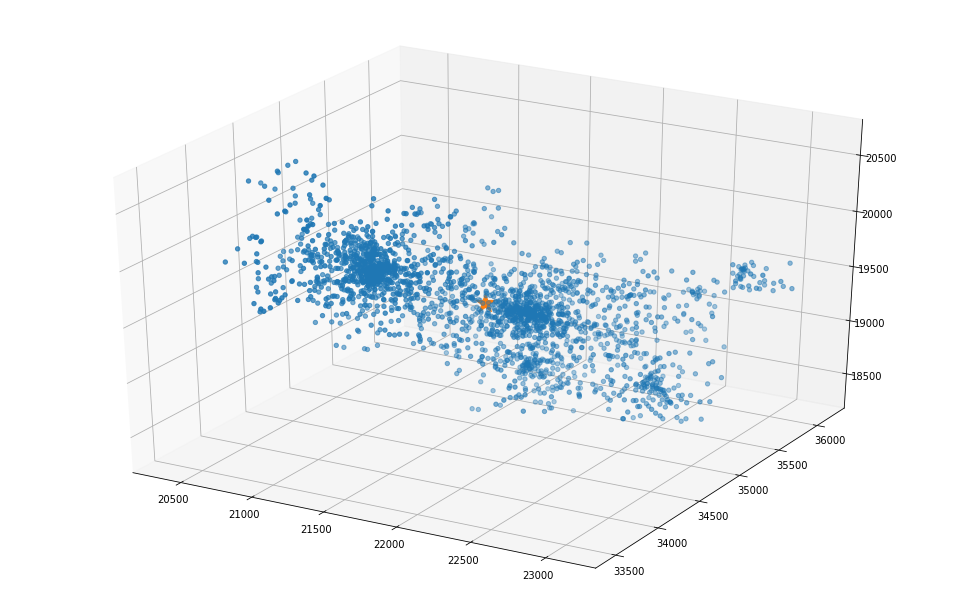

In [100]:
largest_group = groups[np.argmax(np.fromiter(sizes.values(), dtype=float))]
com_largest_halo = np.mean(largest_group, axis=0)
dists_from_com = [np.linalg.norm(np.array(k) - com_largest_halo) for k in largest_group]

fig = plt.figure(figsize=(17, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(largest_group[:,0], largest_group[:,1], largest_group[:,2],marker='.', s=75)
ax.scatter(com_largest_halo[0], com_largest_halo[1], com_largest_halo[2], marker='*', s=400)
plt.show()

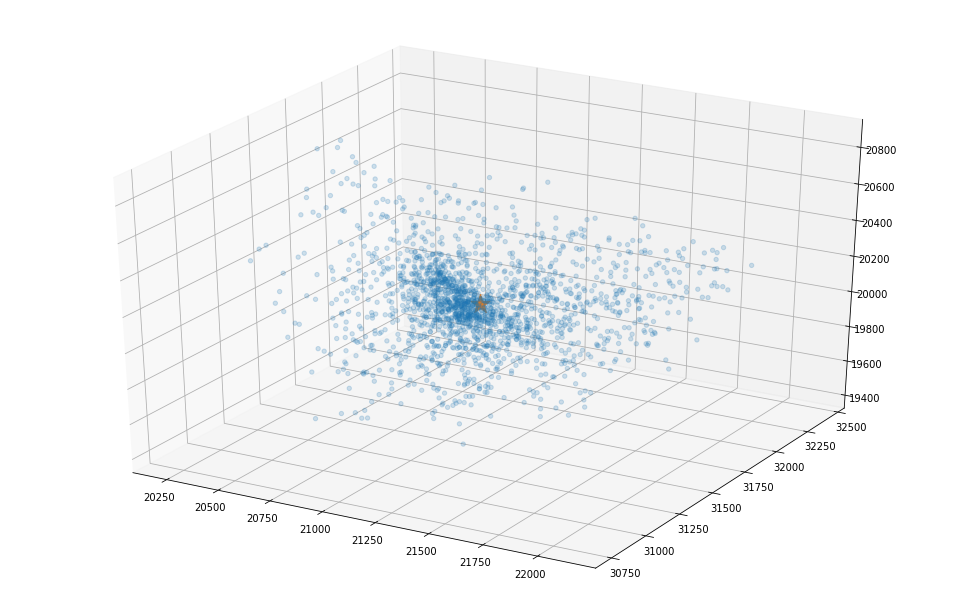

In [113]:
second_largest_group = groups[np.argsort(np.fromiter(sizes.values(), dtype=float))[-2]]
com_second_largest_halo = np.mean(second_largest_group, axis=0)
dists_from_com_2 = [np.linalg.norm(np.array(k) - com_second_largest_halo) for k in second_largest_group]

fig = plt.figure(figsize=(17, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(second_largest_group[:,0], second_largest_group[:,1], second_largest_group[:,2],marker='.', s=75, alpha=0.2)
ax.scatter(com_second_largest_halo[0], com_second_largest_halo[1], com_second_largest_halo[2], marker='*', s=400)
plt.show()

In [159]:
closest_dist_2, largest_dist_2 = min(dists_from_com_2), max(dists_from_com_2)
bins_2 = np.logspace(np.log10(closest_dist_2), np.log10(largest_dist_2), num=20)
sphere_vols = np.array([(4/3)*np.pi*radius**3 for radius in bins_2])
sph_shell_vols = np.diff(sphere_vols)
cts, bin_edges = np.histogram(dists_from_com_2, bins=bins_2)
assert len(sph_shell_vols) == len(cts)

In [160]:
y_axis = cts*mass[0]*1e10/sph_shell_vols
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

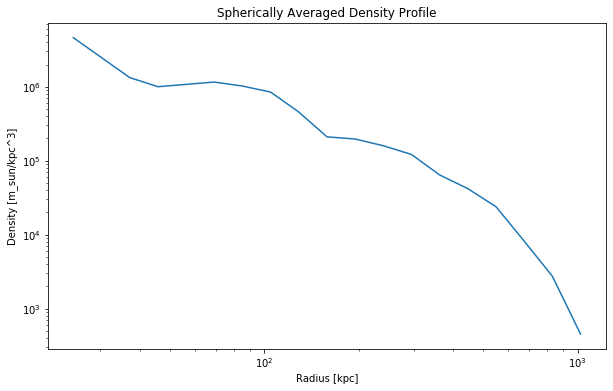

In [162]:
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, y_axis)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Radius [kpc]");
plt.ylabel("Density [m_sun/kpc^3]");
plt.title("Spherically Averaged Density Profile");